# Data Importing

In [47]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2


In [48]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Changable_Parameter**

In [50]:
#here image size is 256x256
IMAGE_SIZE = 200
#every time process 32 images (61x31)~1951
batch_size = 10
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 25
NUM_CLASSES = 8
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=5
data_dir ="E:\\ICCIT\\mango\\MangoLeafBD Dataset\\MangoLeafBD Dataset"
split_folder = "E:\\ICCIT\\mango\\split"
# source_path = 'E:\\ICCIT\\cassava\\dataResized'  # Original dataset directory (with subfolders)
# destination_path = 'E:\\ICCIT\\cassava\\splitResized'  # New directory for split dataset

model_name="inception V3"  

**Directory Creation and split**

In [52]:
import os
import shutil
import random
import math

# Example paths

train_val_dir = os.path.join(split_folder, "train_validation_data")
test_dir = os.path.join(split_folder, "test_data")

def split_data(source_folder, split_folder, train_val_ratio=0.9):
    # Check if split folders already exist
    if os.path.exists(train_val_dir) and os.path.exists(test_dir):
        print("Split folders already exist. Skipping data split.")
        return
    
    # Create split folders if they do not exist
    if not os.path.exists(split_folder):
        os.makedirs(split_folder)
    if not os.path.exists(train_val_dir):
        os.makedirs(train_val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    # Count variables
    train_val_count = 0
    test_count = 0
    
    # Iterate through source_folder (main folder with classes)
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        
        if os.path.isdir(class_path):
            # Create corresponding folders in split_folder
            train_val_class_path = os.path.join(train_val_dir, class_folder)
            test_class_path = os.path.join(test_dir, class_folder)
            
            if not os.path.exists(train_val_class_path):
                os.makedirs(train_val_class_path)
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)
            
            # List all images in the class folder
            images = [img for img in os.listdir(class_path) if img.endswith('.jpg') or img.endswith('.png')]
            random.shuffle(images)
            
            # Calculate split indices
            split_index = int(len(images) * train_val_ratio)
            
            # Split images into train_validation_data and test_data
            train_val_images = images[:split_index]
            test_images = images[split_index:]
            
            # Copy images to respective split folders
            for img in train_val_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(train_val_class_path, img)
                shutil.copy(src, dst)
                train_val_count += 1
                
            for img in test_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(test_class_path, img)
                shutil.copy(src, dst)
                test_count += 1
    
    print("Data split completed successfully.")
    print(f"Number of images in train_validation_data: {train_val_count}")
    print(f"Number of images in test_data: {test_count}")
    print(f"Total number of images: {train_val_count + test_count}")

# Call the function with your paths
split_data(data_dir, split_folder)


Split folders already exist. Skipping data split.


In [53]:
import os
import shutil
import random
import tensorflow as tf
# Define image parameters

# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.10+.03,  # 10% of the data will be used for validation
)

train_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


validation_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical'  # Update for multi-class classification
)


Found 3136 images belonging to 8 classes.
Found 464 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


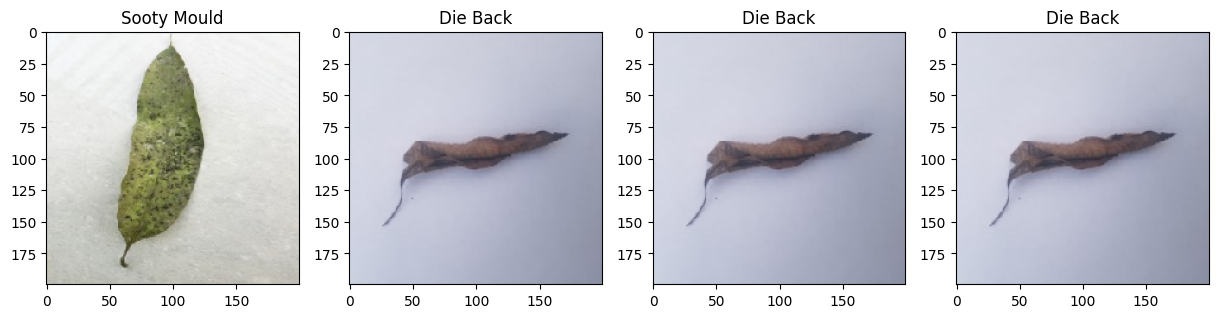

In [54]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, batch_size)
    
    # Plot the image
    axes[i].imshow(images[random_index])
    
    # Get the corresponding label
    label = labels[random_index]
    
    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [56]:
from tensorflow.keras.applications import EfficientNetV2B0,ResNet50,InceptionV3,NASNetMobile,EfficientNetV2L

model= InceptionV3(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                
                 )

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

**Fine Tuning**

In [58]:
for layer in model.layers[:168]:
   layer.trainable = False
for layer in model.layers[168:]:
   layer.trainable = True

# # print('Last block of the conv_base is now trainable')


# for i, layer in enumerate(model.layers):
#    print(i, layer.name, layer.trainable)

In [59]:

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed on top of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    #top_model = Dropout(0.6)(top_model) 
    #top_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model) 
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [60]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)
#print(model.summary())

# Training

In [62]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 5:
         return .0009
     else:
        return .0009

lr_scheduler = LearningRateScheduler(scheduler)

In [63]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model") 
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

**CheckPoints**

In [65]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [66]:


model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    batch_size=batch_size,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,lr_scheduler,check,csv_logger],
                    initial_epoch=0)

Epoch 1/25
314/314 [==============================] - ETA: 0s - loss: 3.8421 - accuracy: 0.8090
Epoch 1: val_loss improved from inf to 2.42149, saving model to Model\inception V3_Model.hdf5
314/314 [==============================] - 39s 97ms/step - loss: 3.8421 - accuracy: 0.8090 - val_loss: 2.4215 - val_accuracy: 0.8190 - lr: 9.0000e-04
Epoch 2/25
314/314 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.9576
Epoch 2: val_loss improved from 2.42149 to 0.46154, saving model to Model\inception V3_Model.hdf5
314/314 [==============================] - 31s 100ms/step - loss: 0.3736 - accuracy: 0.9576 - val_loss: 0.4615 - val_accuracy: 0.9332 - lr: 9.0000e-04
Epoch 3/25
314/314 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9662
Epoch 3: val_loss improved from 0.46154 to 0.26591, saving model to Model\inception V3_Model.hdf5
314/314 [==============================] - 23s 74ms/step - loss: 0.2620 - accuracy: 0.9662 - val_loss: 0.2659 - val_accur

**saving models**

In [68]:
import pickle

pickle_path_json = os.path.join("Results", f"{model_name}_model_architecture.json")
pickle_model_path = os.path.join("Model", f"{model_name}_model_pickle.pkl")

# Save model architecture to JSON (only needed once)
model_architecture = model.to_json()
with open(pickle_path_json, 'w') as f:
    f.write(model_architecture)

# Save model weights using pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://85f578cd-574d-486f-9e1f-e75fb3a64c38/assets


In [69]:
model.save(f'{model_name}_.h5')

In [70]:
model = tf.keras.models.load_model(f'{model_name}_.h5')

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Result

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

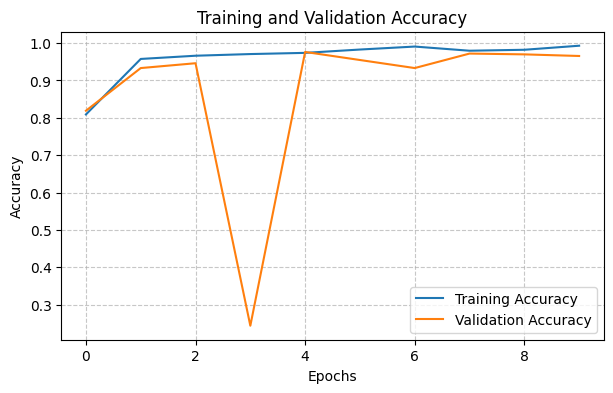

In [74]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

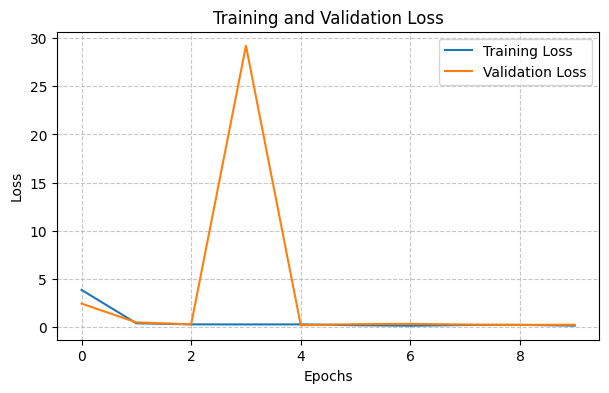

In [75]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
        

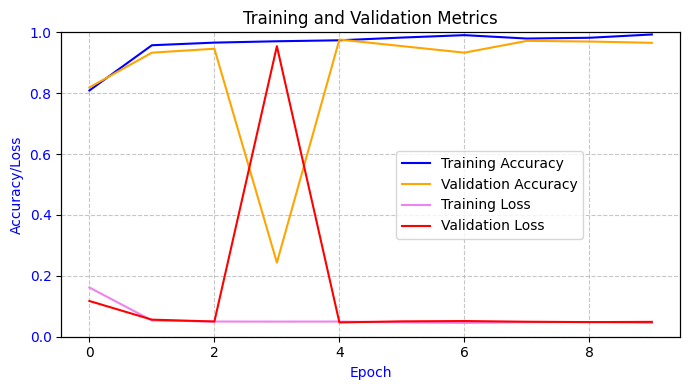

In [76]:
import matplotlib.pyplot as plt

# Assuming the following are defined:
# epochs: list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
# history: training history object containing 'accuracy', 'val_accuracy', 'loss', and 'val_loss' metrics

fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot Training and Validation Accuracy
ax1.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Set y-axis label and limits for accuracy
ax1.set_ylabel('Accuracy/Loss', color='blue')
ax1.set_xlabel('Epoch', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 1])  # Limit y-axis for accuracy between 0 and 1

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], label='Training Loss', color='violet')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')

# Hide y-axis ticks and labels for loss
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_ylabel('')  # Set empty string to hide the label

# Add grid, legends, title, and x-axis label
ax1.grid(True, linestyle='--', alpha=0.7)

# Combine legends for accuracy and loss in the middle right
handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Adjust legend position to be slightly left of center right
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.85, 0.5))

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')

# Show plot
plt.tight_layout()
plt.show()


In [77]:
score = model.evaluate(test_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

40/40 [==============================] - 2s 38ms/step - loss: 0.1029 - accuracy: 0.9925
Test Loss: 0.10291055589914322
Test accuracy: 99.25000071525574


In [78]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_all, y_pred_all, target_names=class_labels, zero_division=1,digits=4)



In [79]:
print(report)

                  precision    recall  f1-score   support

     Anthracnose     1.0000    1.0000    1.0000        50
Bacterial Canker     1.0000    0.9800    0.9899        50
  Cutting Weevil     1.0000    1.0000    1.0000        50
        Die Back     1.0000    1.0000    1.0000        50
      Gall Midge     1.0000    1.0000    1.0000        50
         Healthy     1.0000    1.0000    1.0000        50
  Powdery Mildew     0.9434    1.0000    0.9709        50
     Sooty Mould     1.0000    0.9600    0.9796        50

        accuracy                         0.9925       400
       macro avg     0.9929    0.9925    0.9925       400
    weighted avg     0.9929    0.9925    0.9925       400



In [80]:
pip install numpy --upgrade


  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [81]:
pip install pandas scikit-image seaborn


Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install numpy==1.21.1

  Using cached numpy-1.21.1-cp38-cp38-win_amd64.whl.metadata (2.0 kB)
Using cached numpy-1.21.1-cp38-cp38-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


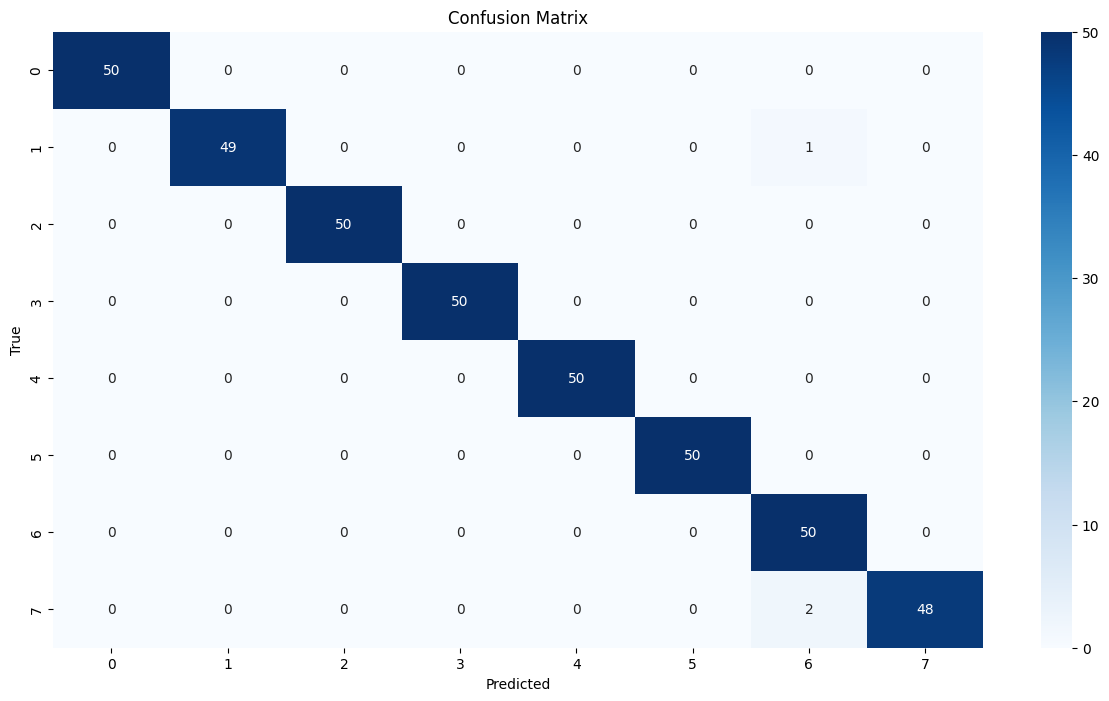

In [83]:
cm = confusion_matrix(y_true_all, y_pred_all)
import seaborn as sns
# Get class labels
class_labels = list(validation_generator.class_indices.keys())
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
# Plot confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

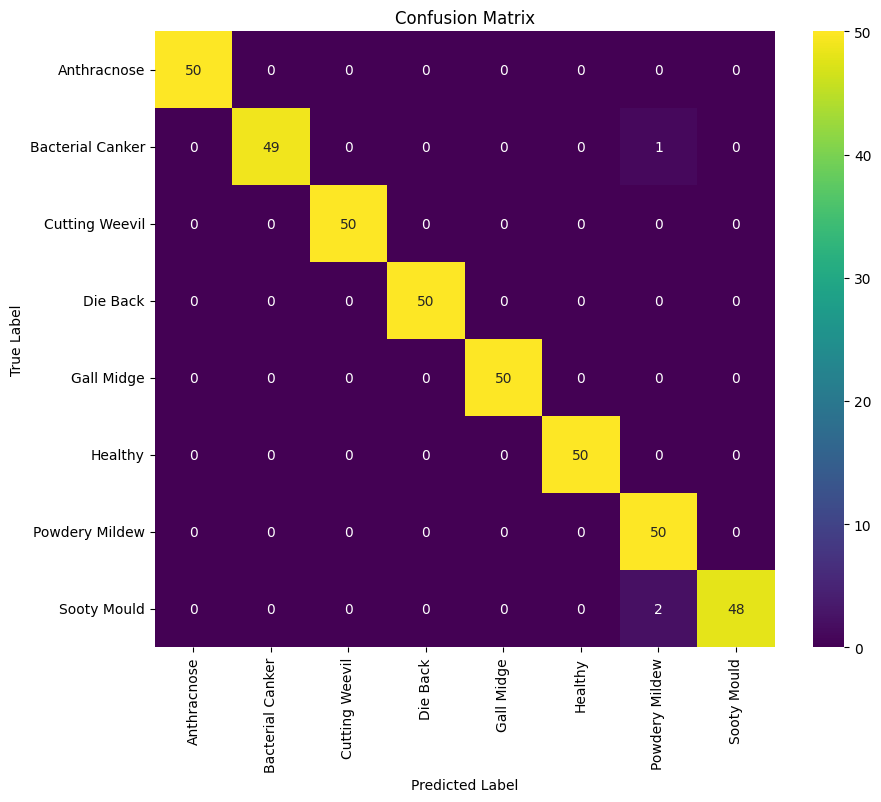

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Plot confusion matrix with a colorful palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [85]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

(400, 8)

In [86]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Calculate specificity for each class
specificity = {}
for i, label in enumerate(class_labels):
    # True Negatives (TN) are all the elements except the row and column of the class i
    tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    # False Positives (FP) are the sum of the i-th column except the i-th element
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity[label] = tn / (tn + fp)



# # Optionally, you can also print the confusion matrix
# print("\nConfusion Matrix:")
# print(conf_matrix)


In [87]:
# Print specificity for each class
for class_label in class_labels:
    print(f"Specificity for class '{class_label}': {specificity[class_label]:.4f}")

Specificity for class 'Anthracnose': 1.0000
Specificity for class 'Bacterial Canker': 1.0000
Specificity for class 'Cutting Weevil': 1.0000
Specificity for class 'Die Back': 1.0000
Specificity for class 'Gall Midge': 1.0000
Specificity for class 'Healthy': 1.0000
Specificity for class 'Powdery Mildew': 0.9914
Specificity for class 'Sooty Mould': 1.0000


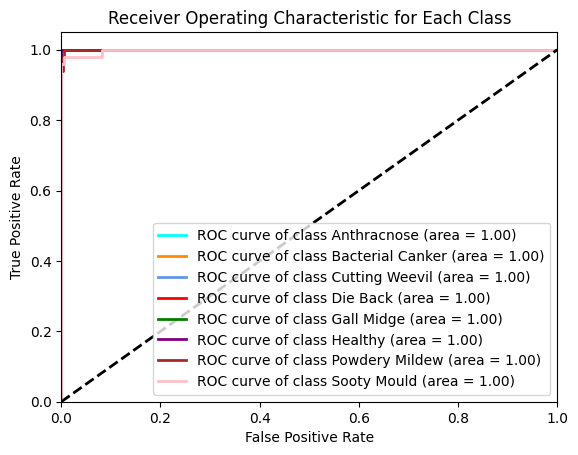

In [88]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []
y_pred_prob_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)
    y_pred_prob_all.extend(y_pred_prob)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Binarize the output
from sklearn.preprocessing import label_binarize
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true_all, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()


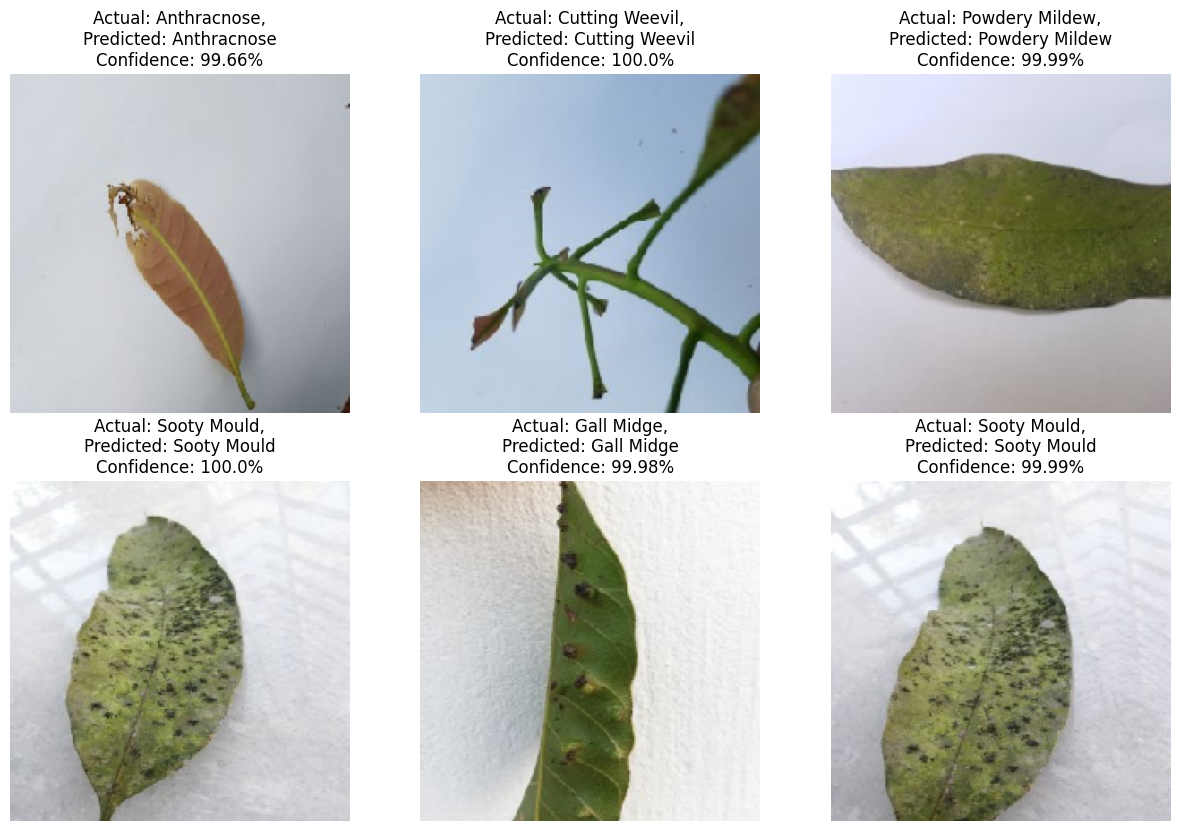

In [89]:
class_names = list(test_generator.class_indices.keys())

# Define the predict function
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add an extra dimension to the array to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Use the model to make predictions on the image
    predictions = model.predict(img_array)

    # Find the index of the class with the highest probability
    predicted_class = class_names[np.argmax(predictions[0])]

    # Get the confidence level of the prediction (probability of the predicted class)
    confidence = round(100 * np.max(predictions[0]), 2)

    # Return the predicted class and confidence level
    return predicted_class, confidence

# Select random images and plot them
plt.figure(figsize=(15, 15))
random_indices = np.random.choice(len(test_generator), 6, replace=False)

for i, idx in enumerate(random_indices):
    # Get the next batch of data
    x_val, y_val = test_generator[idx]
    
    # Select a random image from the batch
    random_image_index = np.random.randint(x_val.shape[0])
    img = x_val[random_image_index]
    actual_class = class_names[np.argmax(y_val[random_image_index])]

    # Predict the class and confidence
    predicted_class, confidence = predict(model, img)

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}%')
    plt.axis('off')

plt.show()

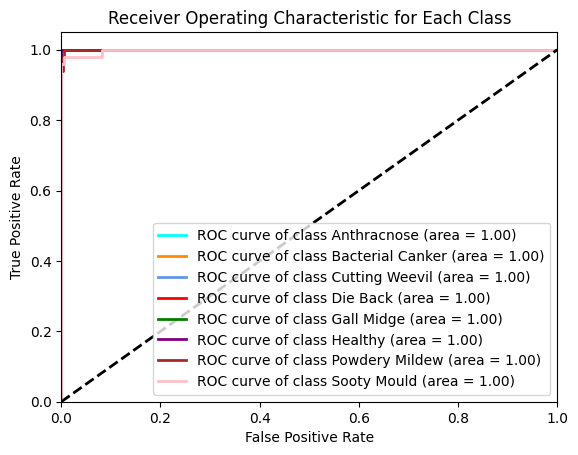

In [90]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []
y_pred_prob_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)
    y_pred_prob_all.extend(y_pred_prob)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Binarize the output
from sklearn.preprocessing import label_binarize
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true_all, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()
